In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as scp

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib as mpl
import csv
from tqdm import notebook
import cmath
import json

In [11]:
class ComplexEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, complex):
            return {"real": obj.real, "imag": obj.imag}
        return super().default(obj)
    
def as_complex(dct):
    if 'real' in dct and 'imag' in dct:
        return complex(dct['real'], dct['imag'])
    return dct

In [12]:
#Define Constants
e = 1.6e-19 #C - charge on electron
m_e = 9.1094e-31 #kg - mass of electron
al = m_e/e #used in matrix
alin = 1/al
mu_0 = 4e-7*np.pi #H/m - permeability of free space
ep_0 = 8.854e-12 #F/m - permitivity of free space
c = 3e8 #m/s - speed of light

In [21]:
file = './SetupOG/38deg_CutSort.json' 
with open(file, 'r') as f:
    jsondata = json.load(f, object_hook=as_complex)
# unpacking:
N = jsondata['N']
L = jsondata['L']
deltax = jsondata['deltax']
wp0 = jsondata['wp0']
thetadegs = jsondata['thetadegs']
Nk = jsondata['Nk']

xlist = jsondata['xlist']
wplist = jsondata['wplist']
eplist = jsondata['eplist']
mulist = jsondata['mulist']

k0list = jsondata['k0list']
evals_list = jsondata['evals_list']
Eavg_list = jsondata['Eavg_list']
Estd_list = jsondata['Estd_list']
Emax_list = jsondata['Emax_list']

### Plot Physical Setup

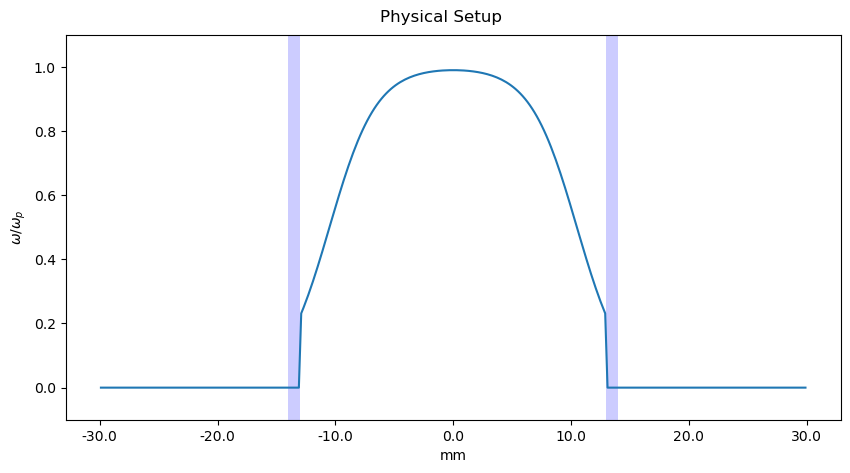

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
fig.suptitle('Physical Setup', y=.93)
ax.plot(xlist, np.divide(wplist, wp0))
for n in range(N):
    if eplist[n] > 1:
        ax.add_patch(patches.Rectangle((xlist[n] - deltax/2, -0.1), deltax, 1.2, color='blue', alpha=0.2, ec=None))
    if eplist[n] < 1:
        ax.add_patch(patches.Rectangle((xlist[n] - deltax/2, -0.1), deltax, 1.2, color='silver', alpha=1, ec=None))
plt.ylim([-0.1,1.1])
xticklist = np.linspace(-L, L, 7)
plt.xticks(xticklist, [round(xt,3) for xt in xticklist*1e3])
plt.xlabel(r'mm')
plt.ylabel(r'$\omega/\omega_p$')
plt.show()

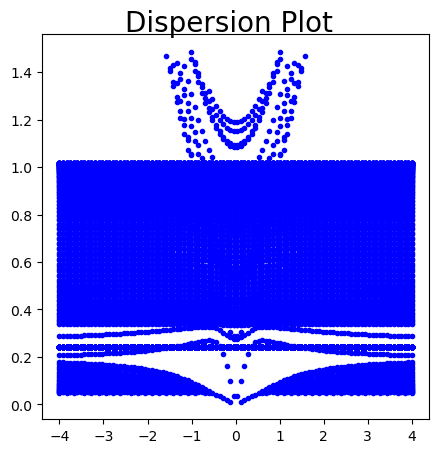

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

fig.suptitle('Dispersion Plot', size=20, y=.93)

for i in range(Nk):
    ax.plot([k0list[i] for n in evals_list[i]], np.asarray(evals_list[i]).real / wp0, 'b.')